In [1]:
# =========================================
# Projeto: Statistical Inference Project
# Etapa: Inferência Bayseana
# Autor: João Victor Barros
# =========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, gamma, beta
import seaborn as sns
from IPython.display import display, Markdown
import os

np.random.seed(42)

from toolkit.utils import savefig

FIG_DIR = "../figures/bayes/" 
os.makedirs(FIG_DIR, exist_ok=True)

plt.style.use('default')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [2]:
file_path = "../data/ndt_tests_corrigido.csv"
try:
    df = pd.read_csv(file_path, parse_dates=[0])
except FileNotFoundError:
    print("Erro: O arquivo '.csv' não foi encontrado. Verifique o caminho.")

df.head()

,timestamp,download_throughput_bps,rtt_download_sec,upload_throughput_bps,rtt_upload_sec,packet_loss_percent,client,server
0,2025-08-09 15:28:02+00:00,8.223657e+07,0.231862,6.973217e+07,0.247727,0.000000,client12,server06
1,2025-08-09 15:30:11+00:00,9.027315e+08,0.012000,8.521780e+08,0.005423,0.008226,client01,server07
2,2025-08-10 04:27:43+00:00,5.910655e+08,0.014000,2.812188e+08,0.014544,5.954284,client13,server07
3,2025-08-09 22:45:07+00:00,6.721139e+08,0.011000,1.135400e+08,0.010482,0.261528,client12,server07
4,2025-08-10 04:49:21+00:00,8.122087e+08,0.009000,6.857905e+08,0.009368,1.381646,client03,server03


**Comparação entre Prior e Posterior (Cliente 13 - rtt_download_sec)**

,Parâmetro,Prior,Posterior
0,$\mu$,0.050000,0.011913
1,$\sigma^2_{\mu}$,0.000400,9.38e-08
2,$\sigma$ (Assumido),-,0.006499


C:\Users\joaov\AppData\Local\Temp\ipykernel_17536\3961823103.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc='upper right')


Figura salva: ../figures/bayes/rtt_download_sec_bayesian_normalnormal_client13.png


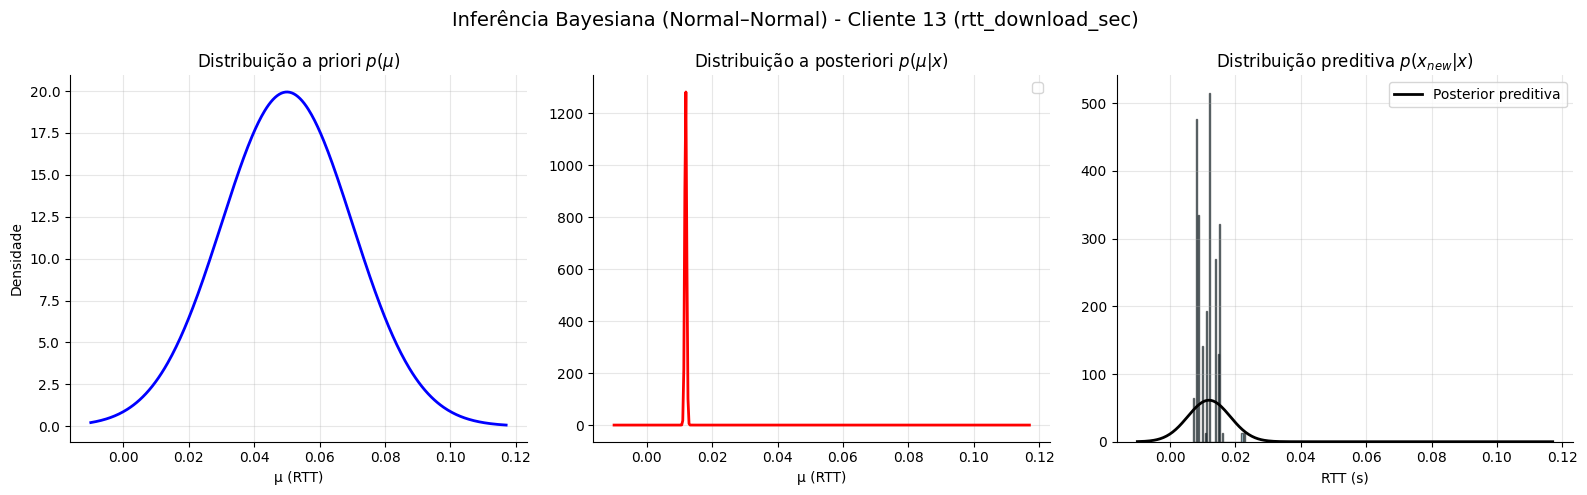


==== rtt_download_sec ====
Empirical mean (x̄) = 0.011904
Posterior mean μ_n = 0.011913
Posterior variance σ_n² = 9.384251e-08
Posterior predictive mean = 0.011913
Posterior predictive std = 0.006506


**Comparação entre Prior e Posterior (Cliente 13 - rtt_upload_sec)**

,Parâmetro,Prior,Posterior
0,$\mu$,0.050000,0.013159
1,$\sigma^2_{\mu}$,0.000400,7.17e-08
2,$\sigma$ (Assumido),-,0.005682


C:\Users\joaov\AppData\Local\Temp\ipykernel_17536\3961823103.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc='upper right')


Figura salva: ../figures/bayes/rtt_upload_sec_bayesian_normalnormal_client13.png


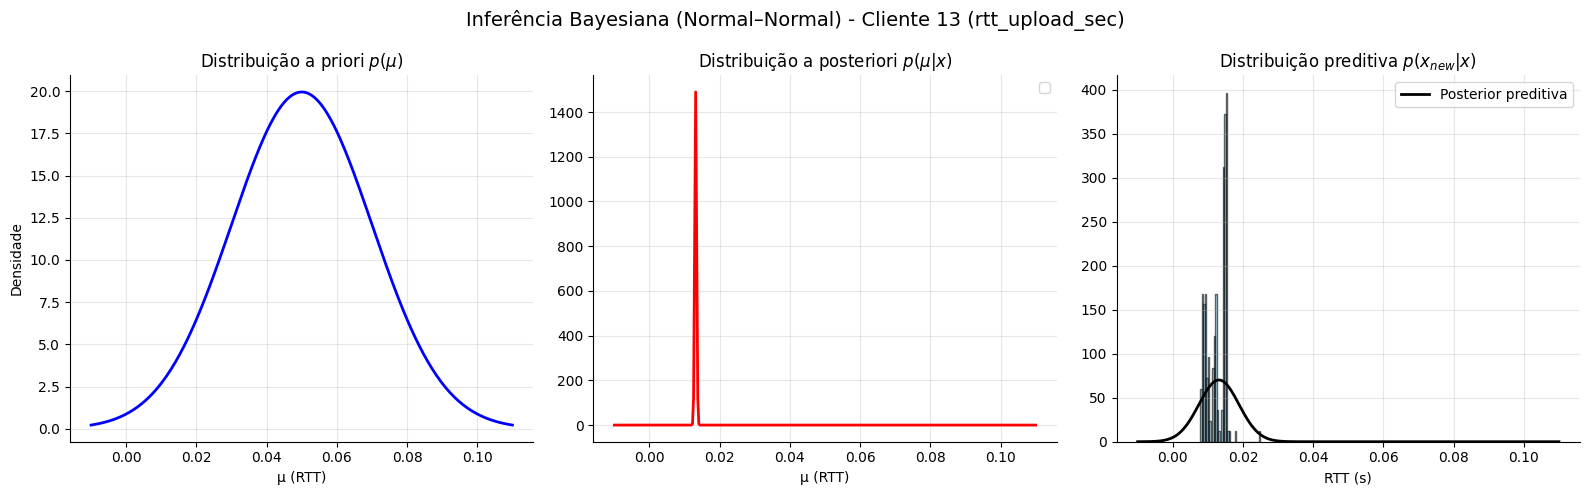


==== rtt_upload_sec ====
Empirical mean (x̄) = 0.013153
Posterior mean μ_n = 0.013159
Posterior variance σ_n² = 7.172945e-08
Posterior predictive mean = 0.013159
Posterior predictive std = 0.005688


In [3]:
client_id = 'client13'
CLIENT_ID_COL = 'client' 
cols = ['rtt_download_sec', 'rtt_upload_sec']

for col in cols:
    df_client = df[df[CLIENT_ID_COL] == client_id] 
    data = df_client[col].dropna().values

    if len(data) < 20:
        print(f"Dados insuficientes para {col} do cliente {client_id}. Pulando.")
        continue

    idx = np.random.permutation(len(data))
    n_train = int(0.7 * len(idx))
    train = data[idx[:n_train]]
    test = data[idx[n_train:]]

    n = len(train)
    xbar = train.mean()
    s2 = train.var(ddof=1)
    mu0 = 0.05
    sigma0 = 0.02
    sigma = np.sqrt(s2)
    sigma_n2 = 1 / (1 / sigma0**2 + n / sigma**2)
    mu_n = sigma_n2 * (mu0 / sigma0**2 + n * xbar / sigma**2)
    pred_mean = mu_n
    pred_var = sigma**2 + sigma_n2
    pred_std = np.sqrt(pred_var)

    df_params = pd.DataFrame({
        'Parâmetro': [r'$\mu$', r'$\sigma^2_{\mu}$', r'$\sigma$ (Assumido)'],
        'Prior': [mu0, sigma0**2, f'-'],
        'Posterior': [mu_n, sigma_n2, f'{sigma:.6f}']
    })

    def format_value(val):
        if isinstance(val, (int, float)):
            return f'{val:.6f}' if abs(val) > 1e-4 else f'{val:.2e}'
        return val

    df_params['Prior'] = df_params['Prior'].apply(format_value)
    df_params['Posterior'] = df_params['Posterior'].apply(format_value)
    display(Markdown(f"**Comparação entre Prior e Posterior (Cliente 13 - {col})**"))
    display(df_params)

    min_data = data.min()
    max_data = data.max()
    x_start = min(min_data, mu0 - 3 * sigma0, mu_n - 3 * np.sqrt(sigma_n2))
    x_end = max(max_data, mu0 + 3 * sigma0, mu_n + 3 * np.sqrt(sigma_n2))
    xs = np.linspace(x_start, x_end, 400)
    pdf_prior = norm.pdf(xs, mu0, sigma0)
    pdf_post = norm.pdf(xs, mu_n, np.sqrt(sigma_n2))
    pdf_pred = norm.pdf(xs, mu_n, pred_std)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    axes[0].plot(xs, pdf_prior, 'b-', lw=2)
    axes[0].set_title('Distribuição a priori $p(μ)$')
    axes[0].set_xlabel('μ (RTT)')
    axes[0].set_ylabel('Densidade')
    axes[0].grid(alpha=0.3)

    axes[1].plot(xs, pdf_post, 'r-', lw=2)
    axes[1].set_title('Distribuição a posteriori $p(μ|x)$')
    axes[1].set_xlabel('μ (RTT)')
    axes[1].grid(alpha=0.3)
    #axes[1].axvline(xbar, color='gray', linestyle='--', label=r'$\bar{x}$ (MLE)')
    #axes[1].axvline(mu_n, color='r', linestyle='-', label=r'$\mu_n$ (Posterior)')
    #axes[1].axvline(mu0, color='b', linestyle=':', label=r'$\mu_0$ (Prior)')
    axes[1].legend(loc='upper right')

    axes[2].hist(test, bins=40, density=True, alpha=0.6, color='skyblue', edgecolor='k')
    axes[2].plot(xs, pdf_pred, 'k-', lw=2, label='Posterior preditiva')
    axes[2].set_title('Distribuição preditiva $p(x_{new}|x)$')
    axes[2].set_xlabel('RTT (s)')
    axes[2].legend()
    axes[2].grid(alpha=0.3)

    plt.suptitle(f'Inferência Bayesiana (Normal–Normal) - Cliente 13 ({col})', fontsize=14)
    plt.tight_layout()
    filename_scatter = f"{col}_bayesian_normalnormal_{client_id}.png"
    savefig(FIG_DIR, filename_scatter, dpi=300)
    plt.show()

    print(f"\n==== {col} ====")
    print(f"Empirical mean (x̄) = {xbar:.6f}")
    print(f"Posterior mean μ_n = {mu_n:.6f}")
    print(f"Posterior variance σ_n² = {sigma_n2:.6e}")
    print(f"Posterior predictive mean = {pred_mean:.6f}")
    print(f"Posterior predictive std = {pred_std:.6f}")

**Tabela de Convergência (Gamma-Gamma) - Cliente 13 (download_throughput_bps)**

,Parâmetro,Prior,Posterior
0,$E[\beta]$ (Média da Taxa),1.00e+06,0.0000
1,$Var[\beta]$ (Variância da Taxa),1.00e+12,0.0000


Figura salva: ../figures/bayes/download_throughput_bps_bayesian_gammagamma_client13.png


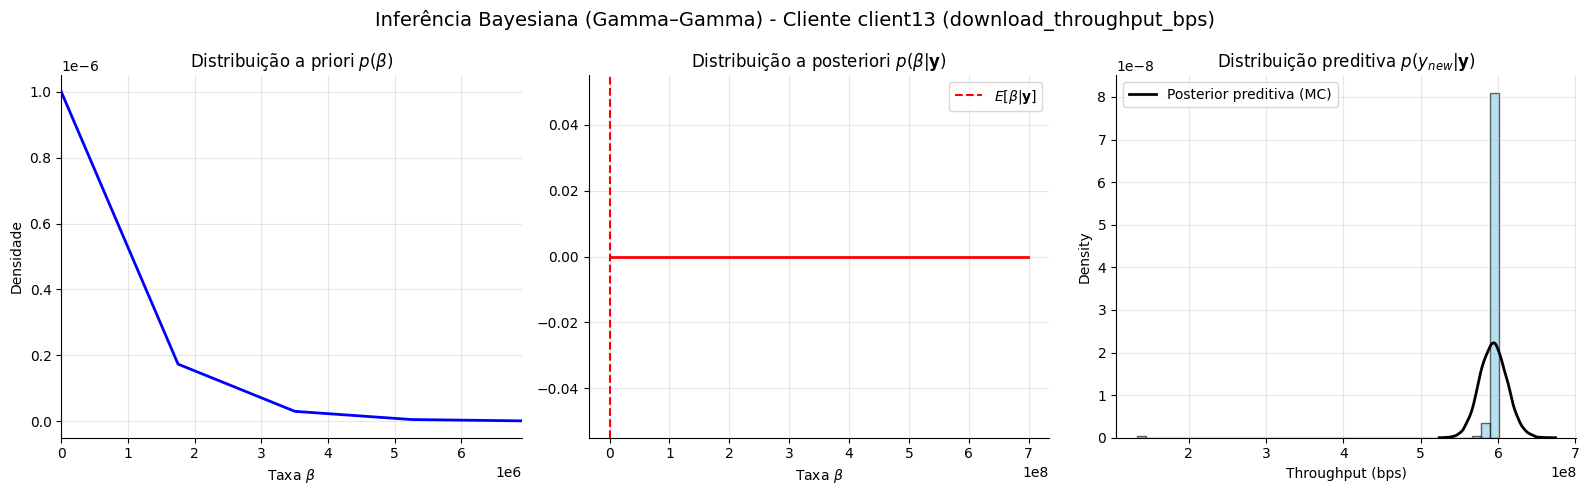


==== download_throughput_bps ====
Taxa MLE (1/θ_mle) = 0.0000
Taxa Posterior E[β] = 0.0000
Throughput Média MLE (k/β_mle) = 594212408.2545
Throughput Média Preditiva (MC) = 594000079.1482


**Tabela de Convergência (Gamma-Gamma) - Cliente 13 (upload_throughput_bps)**

,Parâmetro,Prior,Posterior
0,$E[\beta]$ (Média da Taxa),1.00e+06,0.0000
1,$Var[\beta]$ (Variância da Taxa),1.00e+12,0.0000


Figura salva: ../figures/bayes/upload_throughput_bps_bayesian_gammagamma_client13.png


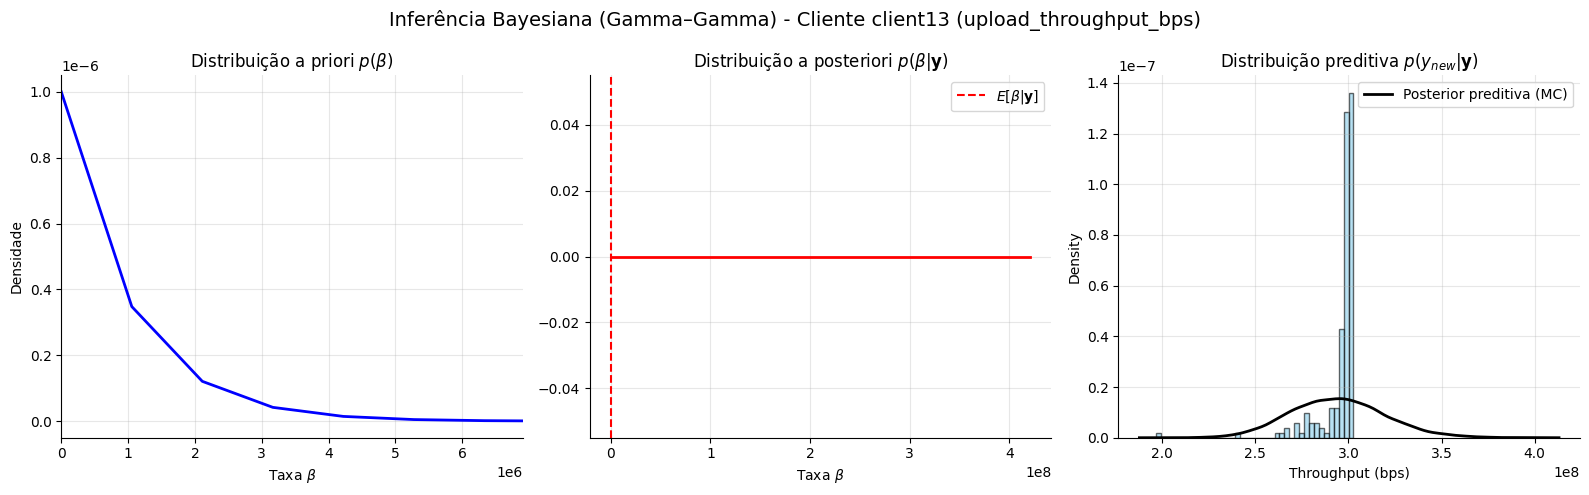


==== upload_throughput_bps ====
Taxa MLE (1/θ_mle) = 0.0000
Taxa Posterior E[β] = 0.0000
Throughput Média MLE (k/β_mle) = 294400030.8102
Throughput Média Preditiva (MC) = 294301648.5280


In [4]:
cols = ['download_throughput_bps', 'upload_throughput_bps']

for col in cols:
    df_client = df[df[CLIENT_ID_COL] == client_id]
    data_all = df_client[col].dropna().values
    data_all = data_all[data_all > 0]
    
    if len(data_all) < 20:
        print(f"Dados insuficientes para {col} do cliente {client_id}. Pulando.")
        continue

    idx = np.random.permutation(len(data_all))
    n_train = int(0.7 * len(idx))
    train = data_all[idx[:n_train]]
    test = data_all[idx[n_train:]]

    n = len(train)
    sum_y = train.sum()
    k_mle, loc_mle, scale_mle = gamma.fit(train, floc=0)
    a0 = 1.0
    b0 = 1e-6
    a_post = a0 + n * k_mle
    b_post = b0 + sum_y
    E_beta0 = a0 / b0
    Var_beta0 = a0 / b0**2
    E_beta_post = a_post / b_post
    Var_beta_post = a_post / b_post**2
    
    df_params = pd.DataFrame({
        'Parâmetro': [r'$E[\beta]$ (Média da Taxa)', r'$Var[\beta]$ (Variância da Taxa)'],
        'Prior': [E_beta0, Var_beta0],
        'Posterior': [E_beta_post, Var_beta_post]
    })

    def format_value(val):
        if isinstance(val, (int, float)):
            # Formatação adaptativa
            return f'{val:.4f}' if abs(val) < 1 else f'{val:.2e}'
        return val

    df_params['Prior'] = df_params['Prior'].apply(format_value)
    df_params['Posterior'] = df_params['Posterior'].apply(format_value)
    display(Markdown(f"**Tabela de Convergência (Gamma-Gamma) - Cliente 13 ({col})**"))
    display(df_params)

    n_samples = 10000
    beta_samples = np.random.gamma(shape=a_post, scale=1.0/b_post, size=n_samples)
    y_preds = np.random.gamma(shape=k_mle, scale=1.0/beta_samples)
    pred_mean = y_preds.mean()
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    x_lim_max = max(y_preds.max(), test.max()) * 1.05
    xs_pdf = np.linspace(0.0, x_lim_max, 400)
    
    axes[0].plot(xs_pdf, gamma.pdf(xs_pdf, a=a0, scale=1/b0), 'b-', lw=2)
    axes[0].set_title(r'Distribuição a priori $p(\beta)$')
    axes[0].set_xlabel(r'Taxa $\beta$')
    axes[0].set_ylabel('Densidade')
    axes[0].set_xlim(0, gamma.ppf(0.999, a=a0, scale=1/b0))
    axes[0].grid(alpha=0.3)

    axes[1].plot(xs_pdf, gamma.pdf(xs_pdf, a=a_post, scale=1/b_post), 'r-', lw=2)
    axes[1].axvline(E_beta_post, color='r', linestyle='--', label=r'$E[\beta|\mathbf{y}]$')
    axes[1].set_title(r'Distribuição a posteriori $p(\beta|\mathbf{y})$')
    axes[1].set_xlabel(r'Taxa $\beta$')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    axes[2].hist(test, bins=40, density=True, alpha=0.6, color='skyblue', edgecolor='k')
    sns.kdeplot(y_preds, ax=axes[2], color='k', lw=2, label='Posterior preditiva (MC)') 
    axes[2].set_title(r'Distribuição preditiva $p(y_{new}|\mathbf{y})$')
    axes[2].set_xlabel('Throughput (bps)')
    axes[2].legend()
    axes[2].grid(alpha=0.3)

    plt.suptitle(f'Inferência Bayesiana (Gamma–Gamma) - Cliente {client_id} ({col})', fontsize=14)
    plt.tight_layout()
    filename_scatter = f"{col}_bayesian_gammagamma_{client_id}.png"
    savefig(FIG_DIR, filename_scatter, dpi=300)
    plt.show()

    print(f"\n==== {col} ====")
    print(f"Taxa MLE (1/θ_mle) = {1/scale_mle:.4f}")
    print(f"Taxa Posterior E[β] = {E_beta_post:.4f}")
    print(f"Throughput Média MLE (k/β_mle) = {k_mle / (1/scale_mle):.4f}")
    print(f"Throughput Média Preditiva (MC) = {pred_mean:.4f}")

**Tabela de Convergência (Beta-Binomial) - Cliente 13 (packet_loss_percent)**

,Parâmetro,Prior,Posterior
0,$E[p]$ (Média da Fração),0.50000000,0.05361310
1,$Var[p]$ (Variância da Fração),0.08333333,1.13e-07


Figura salva: ../figures/bayes/packet_loss_percent_bayesian_betabinomial_client13.png


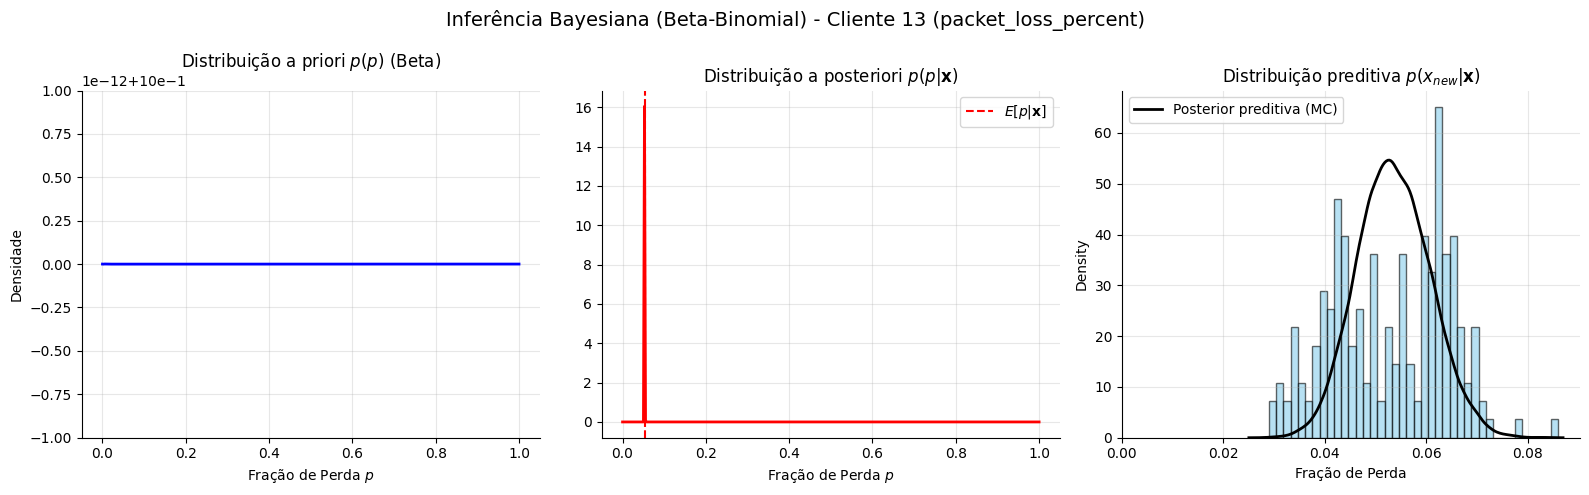


==== packet_loss_percent ====
MLE p̂: 0.05361111
Posterior Média E[p]: 0.05361310
Teste Média: 0.05279381


In [5]:
col = 'packet_loss_percent'
n_packets = 1000
df_client = df[df[CLIENT_ID_COL] == client_id]
loss_percent_all = df_client[col].dropna().values
loss_frac_all = loss_percent_all / 100.0
counts_all = np.round(loss_frac_all * n_packets).astype(int)
counts_all = np.clip(counts_all, 0, n_packets)

if len(counts_all) < 20:
    print(f"Dados insuficientes para {col} do cliente 13. Pulando.")

idx = np.random.permutation(len(counts_all))
n_train = int(0.7 * len(idx))
train_counts = counts_all[idx[:n_train]]
test_counts  = counts_all[idx[n_train:]]

n_train_obs = len(train_counts)
N_trials_total = n_train_obs * n_packets
alpha0 = 1.0
beta0 = 1.0
sum_x = train_counts.sum()
alpha_post = alpha0 + sum_x
beta_post  = beta0 + (N_trials_total - sum_x)
E_p0 = alpha0 / (alpha0 + beta0)
Var_p0 = (alpha0 * beta0) / ((alpha0 + beta0)**2 * (alpha0 + beta0 + 1))
E_p_post = alpha_post / (alpha_post + beta_post)
Var_p_post = (alpha_post * beta_post) / ((alpha_post + beta_post)**2 * (alpha_post + beta_post + 1))

df_params = pd.DataFrame({
    'Parâmetro': [r'$E[p]$ (Média da Fração)', r'$Var[p]$ (Variância da Fração)'],
    'Prior': [E_p0, Var_p0],
    'Posterior': [E_p_post, Var_p_post]
})

def format_value(val):
    if isinstance(val, (int, float)):
        return f'{val:.8f}' if abs(val) > 1e-6 else f'{val:.2e}'
    return val

df_params['Prior'] = df_params['Prior'].apply(format_value)
df_params['Posterior'] = df_params['Posterior'].apply(format_value)
display(Markdown(f"**Tabela de Convergência (Beta-Binomial) - Cliente 13 ({col})**"))
display(df_params)

n_mc_samples = 20000
p_samps = np.random.beta(alpha_post, beta_post, size=n_mc_samples)
count_preds = np.random.binomial(n_packets, p_samps) 
frac_preds = count_preds / n_packets

xs = np.linspace(0.0, 1.0, 400)
pdf_prior = beta.pdf(xs, alpha0, beta0)
pdf_post = beta.pdf(xs, alpha_post, beta_post)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].plot(xs, pdf_prior, 'b-', lw=2)
axes[0].set_title(r'Distribuição a priori $p(p)$ (Beta)')
axes[0].set_xlabel(r'Fração de Perda $p$')
axes[0].set_ylabel('Densidade')
axes[0].grid(alpha=0.3)

axes[1].plot(xs, pdf_post, 'r-', lw=2)
axes[1].axvline(E_p_post, color='r', linestyle='--', label=r'$E[p|\mathbf{x}]$')
axes[1].set_title(r'Distribuição a posteriori $p(p|\mathbf{x})$')
axes[1].set_xlabel(r'Fração de Perda $p$')
axes[1].legend()
axes[1].grid(alpha=0.3)

test_frac = test_counts / n_packets
axes[2].hist(test_frac, bins=40, density=True, alpha=0.6, color='skyblue', edgecolor='k')
sns.kdeplot(frac_preds, ax=axes[2], color='k', lw=2, label='Posterior preditiva (MC)') 
axes[2].set_title(r'Distribuição preditiva $p(x_{new}|\mathbf{x})$')
axes[2].set_xlabel('Fração de Perda')
axes[2].set_xlim(0, max(test_frac.max(), frac_preds.max()) * 1.05)
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.suptitle(f'Inferência Bayesiana (Beta-Binomial) - Cliente 13 ({col})', fontsize=14)
plt.tight_layout()
filename_scatter = f"{col}_bayesian_betabinomial_{client_id}.png"
savefig(FIG_DIR, filename_scatter, dpi=300)
plt.show()

p_mle = sum_x / N_trials_total
test_mean = test_frac.mean()
print(f"\n==== {col} ====")
print(f"MLE p̂: {p_mle:.8f}")
print(f"Posterior Média E[p]: {E_p_post:.8f}")
print(f"Teste Média: {test_mean:.8f}")

In [6]:
df_client = df[df[CLIENT_ID_COL] == client_id] 
summary_rows = []
def mle_normal_params(x): 
    mu = x.mean()
    sigma = np.sqrt(((x - mu)**2).mean()) 
    return mu, sigma

def mle_gamma_params(x):
    a, loc, scale = stats.gamma.fit(x, floc=0)
    return a, scale

def mle_beta_params(x):
    x_clipped = np.clip(x, 1e-6, 1 - 1e-6)
    a, b, loc, scale = stats.beta.fit(x_clipped, floc=0, fscale=1)
    return a, b

col = 'rtt_download_sec'
data_all = df_client[col].dropna().values
idx = np.random.permutation(len(data_all)); nt = int(0.7 * len(idx))
train = data_all[idx[:nt]]; test = data_all[idx[nt:]]
mu_mle, sigma_mle = mle_normal_params(train)
mu0, kappa0, alpha0, beta0 = 0.05, 1.0, 2.0, 1e-4
n = len(train); xbar = train.mean(); S = ((train - xbar)**2).sum()
kappa_n = kappa0 + n; mu_n = (kappa0 * mu0 + n * xbar) / kappa_n
alpha_n = alpha0 + n/2; beta_n = beta0 + 0.5 * S + 0.5 * (kappa0 * n * (xbar - mu0)**2) / kappa_n
pred_mean = mu_n
pred_var = (beta_n / (alpha_n - 1)) * (kappa_n + 1) / kappa_n if alpha_n > 1 else np.nan
summary_rows.append((
    col,
    'Normal (NIΓ)',
    f"MLE μ={mu_mle:.4g}",
    f"Bayes μ={mu_n:.4g}",
    pred_mean,
    pred_var,
    test.mean(),
    test.var(ddof=0)
))

col = 'rtt_upload_sec'
data_all = df_client[col].dropna().values # <--- FILTRADO
idx = np.random.permutation(len(data_all)); nt = int(0.7 * len(idx))
train = data_all[idx[:nt]]; test = data_all[idx[nt:]]
mu_mle, sigma_mle = mle_normal_params(train)
mu0, kappa0, alpha0, beta0 = 0.05, 1.0, 2.0, 1e-4
n = len(train); xbar = train.mean(); S = ((train - xbar)**2).sum()
kappa_n = kappa0 + n; mu_n = (kappa0 * mu0 + n * xbar) / kappa_n
alpha_n = alpha0 + n/2; beta_n = beta0 + 0.5 * S + 0.5 * (kappa0 * n * (xbar - mu0)**2) / kappa_n
pred_mean = mu_n
pred_var = (beta_n / (alpha_n - 1)) * (kappa_n + 1) / kappa_n if alpha_n > 1 else np.nan
summary_rows.append((
    col,
    'Normal (NIΓ)',
    f"MLE μ={mu_mle:.4g}",
    f"Bayes μ={mu_n:.4g}",
    pred_mean,
    pred_var,
    test.mean(),
    test.var(ddof=0)
))

col = 'download_throughput_bps'
data_all = df_client[col].dropna().values
data_all = data_all[data_all > 0]
idx = np.random.permutation(len(data_all)); nt = int(0.7 * len(idx))
train = data_all[idx[:nt]]; test = data_all[idx[nt:]]
k_mle, theta_mle = mle_gamma_params(train)
beta_mle = 1.0 / theta_mle
mle_mean = k_mle / beta_mle
a0, b0 = 1.0, 1e-6
a_post = a0 + len(train) * k_mle
b_post = b0 + train.sum()
E_beta_post = a_post / b_post
mc = 6000
beta_samps = np.random.gamma(shape=a_post, scale=1.0 / b_post, size=mc)
y_preds = np.random.gamma(shape=k_mle, scale=1.0 / beta_samps)
pred_mean = y_preds.mean(); pred_var = y_preds.var(ddof=0)
summary_rows.append((
    col,
    'Gamma-Gamma',
    f"MLE mean={mle_mean:.4g}",
    f"Bayes E[β]={E_beta_post:.4g}",
    pred_mean,
    pred_var,
    test.mean(),
    test.var(ddof=0)
))

col = 'upload_throughput_bps'
data_all = df_client[col].dropna().values
data_all = data_all[data_all > 0]
idx = np.random.permutation(len(data_all)); nt = int(0.7 * len(idx))
train = data_all[idx[:nt]]; test = data_all[idx[nt:]]
k_mle, theta_mle = mle_gamma_params(train)
beta_mle = 1.0 / theta_mle
mle_mean = k_mle / beta_mle
a0, b0 = 1.0, 1e-6
a_post = a0 + len(train) * k_mle
b_post = b0 + train.sum()
E_beta_post = a_post / b_post
mc = 6000
beta_samps = np.random.gamma(shape=a_post, scale=1.0 / b_post, size=mc)
y_preds = np.random.gamma(shape=k_mle, scale=1.0 / beta_samps)
pred_mean = y_preds.mean(); pred_var = y_preds.var(ddof=0)
summary_rows.append((
    col,
    'Gamma-Gamma',
    f"MLE mean={mle_mean:.4g}",
    f"Bayes E[β]={E_beta_post:.4g}",
    pred_mean,
    pred_var,
    test.mean(),
    test.var(ddof=0)
))

col = 'packet_loss_percent'
n_packets = 1000
loss_frac = df_client[col].dropna().values / 100.0
counts = np.round(loss_frac * n_packets).astype(int)
counts = np.clip(counts, 0, n_packets)
idx = np.random.permutation(len(counts)); nt = int(0.7 * len(idx))
train_counts = counts[idx[:nt]]; test_counts = counts[idx[nt]:]
alpha0, beta0 = 1.0, 1.0
sum_x = train_counts.sum()
N_train = len(train_counts) * n_packets
alpha_post = alpha0 + sum_x
beta_post  = beta0 + (N_train - sum_x)
post_mean_p = alpha_post / (alpha_post + beta_post)
p_mle = sum_x / N_train
mc = 10000
p_samps = np.random.beta(alpha_post, beta_post, size=mc)
count_preds = np.random.binomial(n_packets, p_samps)
pred_mean_frac = count_preds.mean() / n_packets
pred_var_frac  = count_preds.var(ddof=0) / (n_packets**2)

summary_rows.append((
    col,
    'Beta-Binomial',
    f"MLE p={p_mle:.6g}",
    f"Bayes E[p]={post_mean_p:.6g}",
    pred_mean_frac,
    pred_var_frac,
    test_counts.mean() / n_packets,
    test_counts.var(ddof=0) / (n_packets**2)
))

summary_df = pd.DataFrame(summary_rows, columns=['variable', 'model', 'mle_point', 'bayes_point', 'pred_mean', 'pred_var', 'test_mean', 'test_var'])
pd.options.display.float_format = '{:.6e}'.format
display(summary_df)

,variable,model,mle_point,bayes_point,pred_mean,pred_var,test_mean,test_var
0,rtt_download_sec,Normal (NIΓ),MLE μ=0.01174,Bayes μ=0.01183,1.182621e-02,4.577163e-05,1.176265e-02,8.185980e-06
1,rtt_upload_sec,Normal (NIΓ),MLE μ=0.01296,Bayes μ=0.01304,1.304128e-02,2.241870e-05,1.304954e-02,3.865316e-05
2,download_throughput_bps,Gamma-Gamma,MLE mean=5.943e+08,Bayes E[β]=1.901e-06,5.939643e+08,3.164547e+14,5.930400e+08,1.108955e+15
3,upload_throughput_bps,Gamma-Gamma,MLE mean=2.945e+08,Bayes E[β]=4.526e-07,2.945671e+08,6.244366e+14,2.954811e+08,1.325131e+14
4,packet_loss_percent,Beta-Binomial,MLE p=0.0524911,Bayes E[p]=0.0524931,5.249870e-02,4.973060e-05,5.312879e-02,1.496349e-04


**Comparação entre Prior e Posterior (Servidor 2 - rtt_download_sec)**

,Parâmetro,Prior,Posterior
0,$\mu$,0.050000,0.011533
1,$\sigma^2_{\mu}$,0.000400,1.82e-08
2,$\sigma$ (Assumido),-,0.002705


Figura salva: ../figures/bayes/rtt_download_sec_bayesian_normalnormal_server02.png


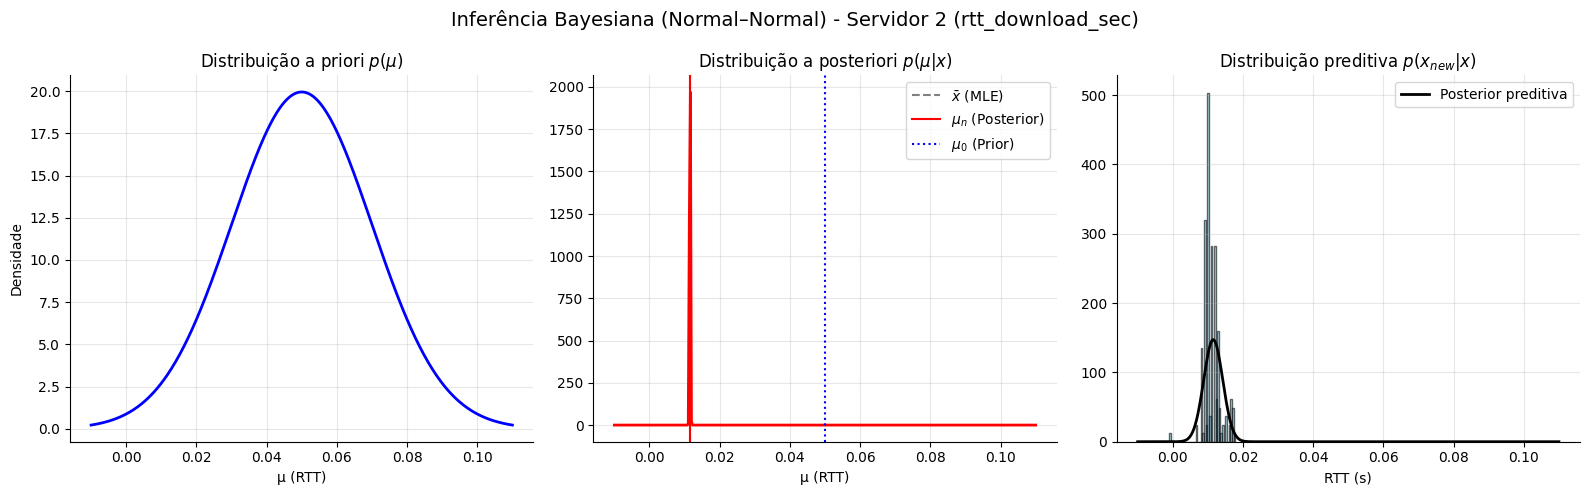


==== rtt_download_sec ====
Empirical mean (x̄) = 0.011531
Posterior mean μ_n = 0.011533
Posterior variance σ_n² = 1.815035e-08
Posterior predictive mean = 0.011533
Posterior predictive std = 0.002708


**Comparação entre Prior e Posterior (Servidor 2 - rtt_upload_sec)**

,Parâmetro,Prior,Posterior
0,$\mu$,0.050000,0.012844
1,$\sigma^2_{\mu}$,0.000400,4.43e-08
2,$\sigma$ (Assumido),-,0.004227


Figura salva: ../figures/bayes/rtt_upload_sec_bayesian_normalnormal_server02.png


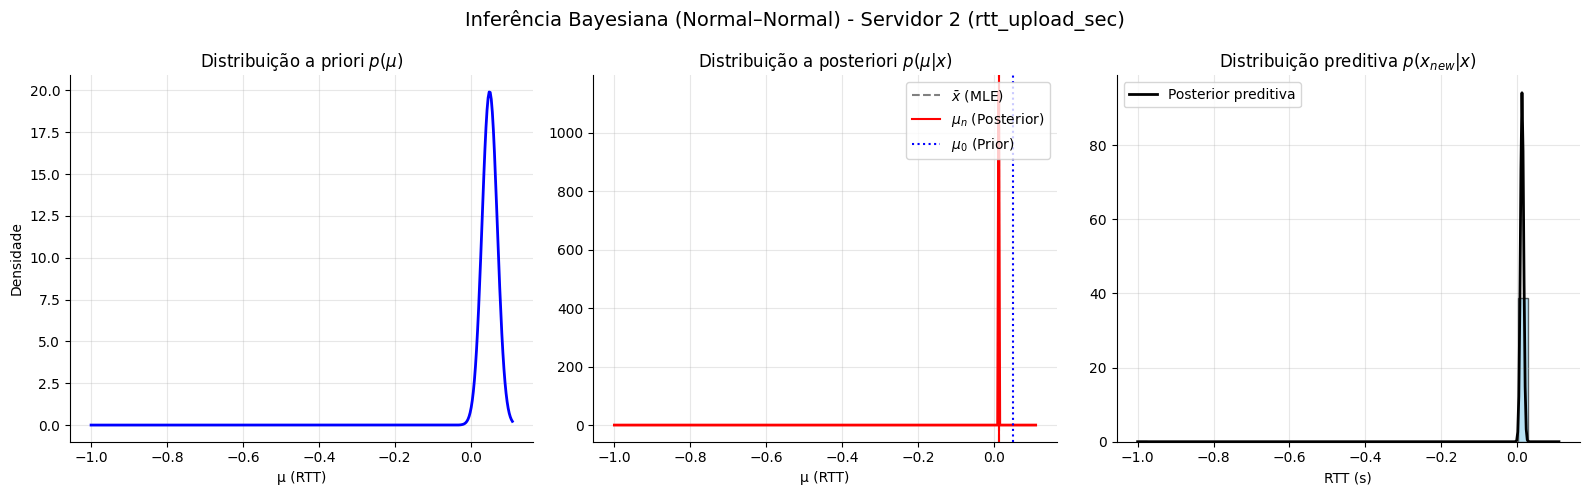


==== rtt_upload_sec ====
Empirical mean (x̄) = 0.012840
Posterior mean μ_n = 0.012844
Posterior variance σ_n² = 4.432388e-08
Posterior predictive mean = 0.012844
Posterior predictive std = 0.004232


In [7]:
client_id = 'server02'
CLIENT_ID_COL = 'server' 
cols = ['rtt_download_sec', 'rtt_upload_sec']

for col in cols:
    df_client = df[df[CLIENT_ID_COL] == client_id] 
    data = df_client[col].dropna().values

    if len(data) < 20:
        print(f"Dados insuficientes para {col} do Servidor 2. Pulando.")
        continue

    idx = np.random.permutation(len(data))
    n_train = int(0.7 * len(idx))
    train = data[idx[:n_train]]
    test = data[idx[n_train:]]

    n = len(train)
    xbar = train.mean()
    s2 = train.var(ddof=1)
    mu0 = 0.05
    sigma0 = 0.02
    sigma = np.sqrt(s2)
    sigma_n2 = 1 / (1 / sigma0**2 + n / sigma**2)
    mu_n = sigma_n2 * (mu0 / sigma0**2 + n * xbar / sigma**2)
    pred_mean = mu_n
    pred_var = sigma**2 + sigma_n2
    pred_std = np.sqrt(pred_var)

    df_params = pd.DataFrame({
        'Parâmetro': [r'$\mu$', r'$\sigma^2_{\mu}$', r'$\sigma$ (Assumido)'],
        'Prior': [mu0, sigma0**2, f'-'],
        'Posterior': [mu_n, sigma_n2, f'{sigma:.6f}']
    })

    def format_value(val):
        if isinstance(val, (int, float)):
            return f'{val:.6f}' if abs(val) > 1e-4 else f'{val:.2e}'
        return val

    df_params['Prior'] = df_params['Prior'].apply(format_value)
    df_params['Posterior'] = df_params['Posterior'].apply(format_value)
    display(Markdown(f"**Comparação entre Prior e Posterior (Servidor 2 - {col})**"))
    display(df_params)

    min_data = data.min()
    max_data = data.max()
    x_start = min(min_data, mu0 - 3 * sigma0, mu_n - 3 * np.sqrt(sigma_n2))
    x_end = max(max_data, mu0 + 3 * sigma0, mu_n + 3 * np.sqrt(sigma_n2))
    xs = np.linspace(x_start, x_end, 400)
    pdf_prior = norm.pdf(xs, mu0, sigma0)
    pdf_post = norm.pdf(xs, mu_n, np.sqrt(sigma_n2))
    pdf_pred = norm.pdf(xs, mu_n, pred_std)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    axes[0].plot(xs, pdf_prior, 'b-', lw=2)
    axes[0].set_title('Distribuição a priori $p(μ)$')
    axes[0].set_xlabel('μ (RTT)')
    axes[0].set_ylabel('Densidade')
    axes[0].grid(alpha=0.3)

    axes[1].plot(xs, pdf_post, 'r-', lw=2)
    axes[1].set_title('Distribuição a posteriori $p(μ|x)$')
    axes[1].set_xlabel('μ (RTT)')
    axes[1].grid(alpha=0.3)
    axes[1].axvline(xbar, color='gray', linestyle='--', label=r'$\bar{x}$ (MLE)')
    axes[1].axvline(mu_n, color='r', linestyle='-', label=r'$\mu_n$ (Posterior)')
    axes[1].axvline(mu0, color='b', linestyle=':', label=r'$\mu_0$ (Prior)')
    axes[1].legend(loc='upper right')

    axes[2].hist(test, bins=40, density=True, alpha=0.6, color='skyblue', edgecolor='k')
    axes[2].plot(xs, pdf_pred, 'k-', lw=2, label='Posterior preditiva')
    axes[2].set_title('Distribuição preditiva $p(x_{new}|x)$')
    axes[2].set_xlabel('RTT (s)')
    axes[2].legend()
    axes[2].grid(alpha=0.3)

    plt.suptitle(f'Inferência Bayesiana (Normal–Normal) - Servidor 2 ({col})', fontsize=14)
    plt.tight_layout()
    filename_scatter = f"{col}_bayesian_normalnormal_{client_id}.png"
    savefig(FIG_DIR, filename_scatter, dpi=300)
    plt.show()

    print(f"\n==== {col} ====")
    print(f"Empirical mean (x̄) = {xbar:.6f}")
    print(f"Posterior mean μ_n = {mu_n:.6f}")
    print(f"Posterior variance σ_n² = {sigma_n2:.6e}")
    print(f"Posterior predictive mean = {pred_mean:.6f}")
    print(f"Posterior predictive std = {pred_std:.6f}")

**Tabela de Convergência (Gamma-Gamma) - Servidor 2 (download_throughput_bps)**

,Parâmetro,Prior,Posterior
0,$E[\beta]$ (Média da Taxa),1.00e+06,0.0000
1,$Var[\beta]$ (Variância da Taxa),1.00e+12,0.0000


Figura salva: ../figures/bayes/download_throughput_bps_bayesian_gammagamma_server02.png


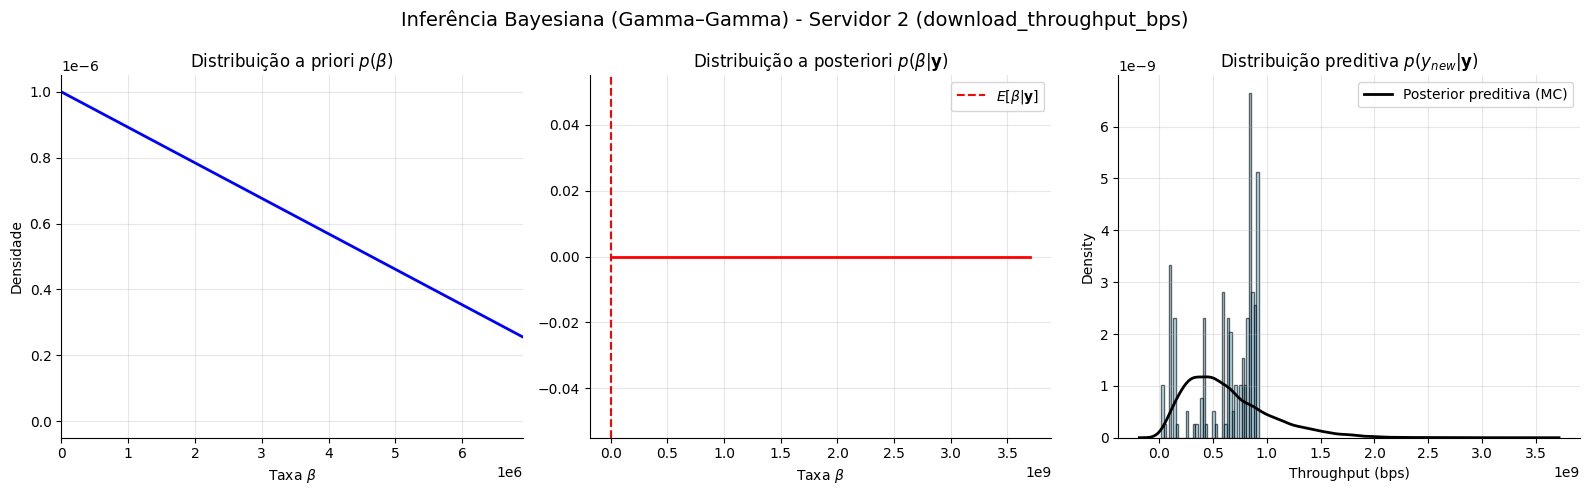


==== download_throughput_bps ====
Taxa MLE (1/θ_mle) = 0.0000
Taxa Posterior E[β] = 0.0000
Throughput Média MLE (k/β_mle) = 636943955.1316
Throughput Média Preditiva (MC) = 633512749.6619


**Tabela de Convergência (Gamma-Gamma) - Servidor 2 (upload_throughput_bps)**

,Parâmetro,Prior,Posterior
0,$E[\beta]$ (Média da Taxa),1.00e+06,0.0000
1,$Var[\beta]$ (Variância da Taxa),1.00e+12,0.0000


Figura salva: ../figures/bayes/upload_throughput_bps_bayesian_gammagamma_server02.png


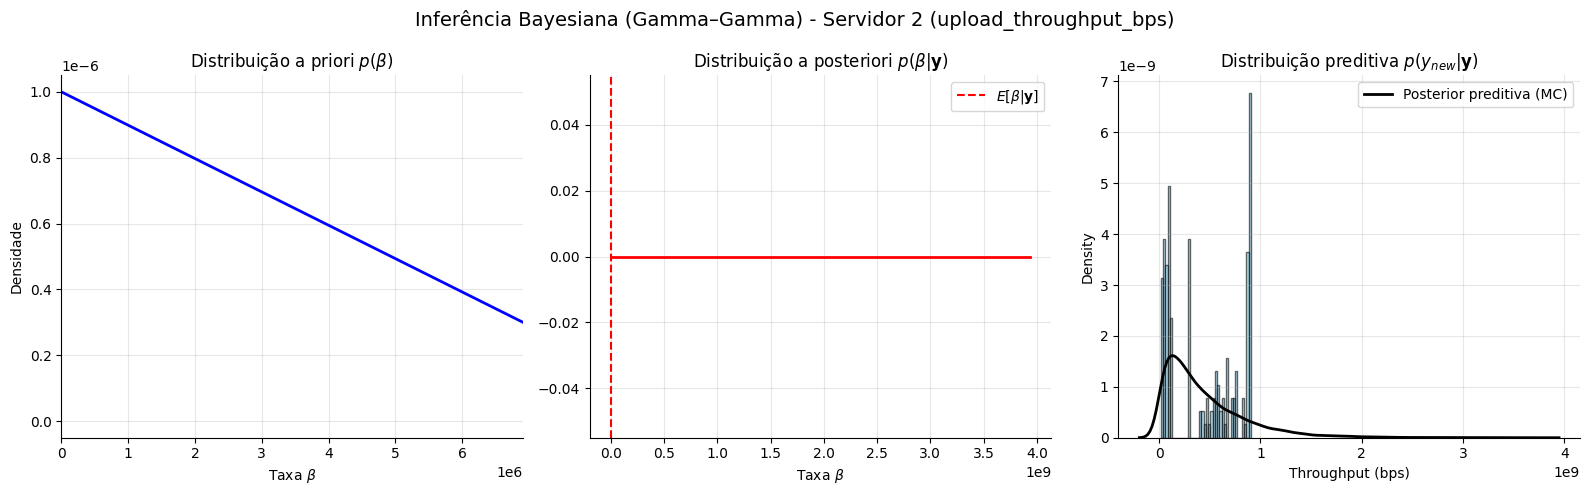


==== upload_throughput_bps ====
Taxa MLE (1/θ_mle) = 0.0000
Taxa Posterior E[β] = 0.0000
Throughput Média MLE (k/β_mle) = 441930474.0324
Throughput Média Preditiva (MC) = 441543130.3529


In [8]:
cols = ['download_throughput_bps', 'upload_throughput_bps']

for col in cols:
    df_client = df[df[CLIENT_ID_COL] == client_id]
    data_all = df_client[col].dropna().values
    data_all = data_all[data_all > 0]
    
    if len(data_all) < 20:
        print(f"Dados insuficientes para {col} do Servidor 2. Pulando.")
        continue

    idx = np.random.permutation(len(data_all))
    n_train = int(0.7 * len(idx))
    train = data_all[idx[:n_train]]
    test = data_all[idx[n_train:]]

    n = len(train)
    sum_y = train.sum()
    k_mle, loc_mle, scale_mle = gamma.fit(train, floc=0)
    a0 = 1.0
    b0 = 1e-6
    a_post = a0 + n * k_mle
    b_post = b0 + sum_y
    E_beta0 = a0 / b0
    Var_beta0 = a0 / b0**2
    E_beta_post = a_post / b_post
    Var_beta_post = a_post / b_post**2
    
    df_params = pd.DataFrame({
        'Parâmetro': [r'$E[\beta]$ (Média da Taxa)', r'$Var[\beta]$ (Variância da Taxa)'],
        'Prior': [E_beta0, Var_beta0],
        'Posterior': [E_beta_post, Var_beta_post]
    })

    def format_value(val):
        if isinstance(val, (int, float)):
            # Formatação adaptativa
            return f'{val:.4f}' if abs(val) < 1 else f'{val:.2e}'
        return val

    df_params['Prior'] = df_params['Prior'].apply(format_value)
    df_params['Posterior'] = df_params['Posterior'].apply(format_value)
    display(Markdown(f"**Tabela de Convergência (Gamma-Gamma) - Servidor 2 ({col})**"))
    display(df_params)

    n_samples = 10000
    beta_samples = np.random.gamma(shape=a_post, scale=1.0/b_post, size=n_samples)
    y_preds = np.random.gamma(shape=k_mle, scale=1.0/beta_samples)
    pred_mean = y_preds.mean()
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    x_lim_max = max(y_preds.max(), test.max()) * 1.05
    xs_pdf = np.linspace(0.0, x_lim_max, 400)
    
    axes[0].plot(xs_pdf, gamma.pdf(xs_pdf, a=a0, scale=1/b0), 'b-', lw=2)
    axes[0].set_title(r'Distribuição a priori $p(\beta)$')
    axes[0].set_xlabel(r'Taxa $\beta$')
    axes[0].set_ylabel('Densidade')
    axes[0].set_xlim(0, gamma.ppf(0.999, a=a0, scale=1/b0))
    axes[0].grid(alpha=0.3)

    axes[1].plot(xs_pdf, gamma.pdf(xs_pdf, a=a_post, scale=1/b_post), 'r-', lw=2)
    axes[1].axvline(E_beta_post, color='r', linestyle='--', label=r'$E[\beta|\mathbf{y}]$')
    axes[1].set_title(r'Distribuição a posteriori $p(\beta|\mathbf{y})$')
    axes[1].set_xlabel(r'Taxa $\beta$')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    axes[2].hist(test, bins=40, density=True, alpha=0.6, color='skyblue', edgecolor='k')
    sns.kdeplot(y_preds, ax=axes[2], color='k', lw=2, label='Posterior preditiva (MC)') 
    axes[2].set_title(r'Distribuição preditiva $p(y_{new}|\mathbf{y})$')
    axes[2].set_xlabel('Throughput (bps)')
    axes[2].legend()
    axes[2].grid(alpha=0.3)

    plt.suptitle(f'Inferência Bayesiana (Gamma–Gamma) - Servidor 2 ({col})', fontsize=14)
    plt.tight_layout()
    filename_scatter = f"{col}_bayesian_gammagamma_{client_id}.png"
    savefig(FIG_DIR, filename_scatter, dpi=300)
    plt.show()

    print(f"\n==== {col} ====")
    print(f"Taxa MLE (1/θ_mle) = {1/scale_mle:.4f}")
    print(f"Taxa Posterior E[β] = {E_beta_post:.4f}")
    print(f"Throughput Média MLE (k/β_mle) = {k_mle / (1/scale_mle):.4f}")
    print(f"Throughput Média Preditiva (MC) = {pred_mean:.4f}")

**Tabela de Convergência (Beta-Binomial) - Servidor 2 (packet_loss_percent)**

,Parâmetro,Prior,Posterior
0,$E[p]$ (Média da Fração),0.50000000,0.02143662
1,$Var[p]$ (Variância da Fração),0.08333333,5.21e-08


Figura salva: ../figures/bayes/packet_loss_percent_bayesian_betabinomial_server02.png


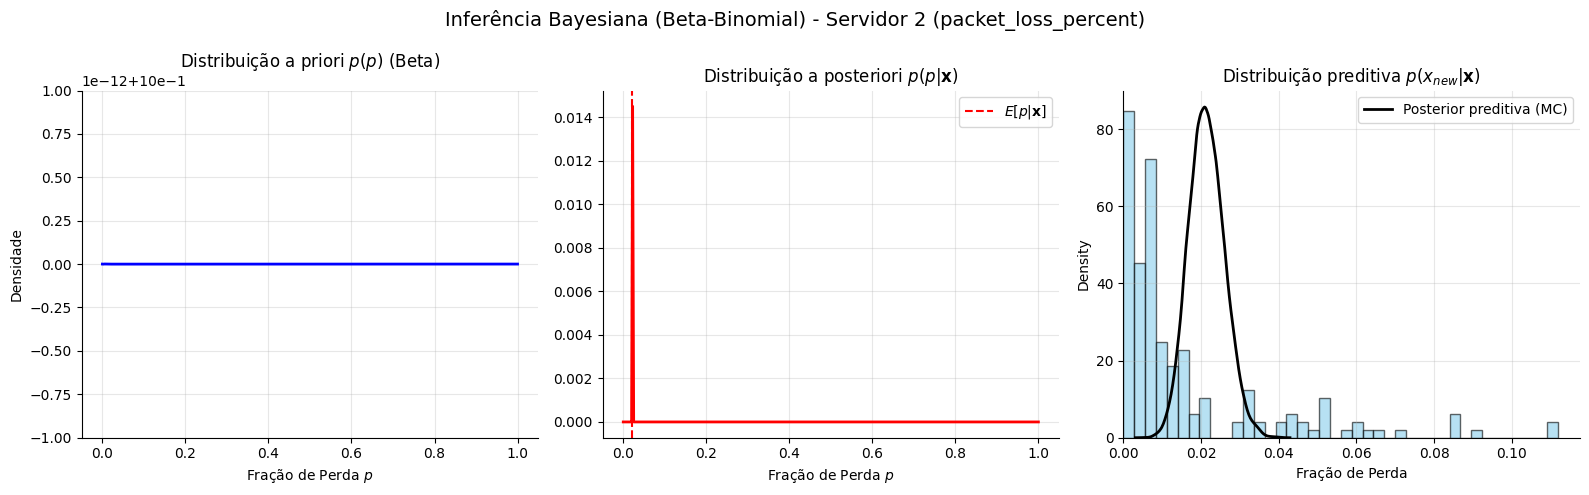


==== packet_loss_percent ====
MLE p̂: 0.02143424
Posterior Média E[p]: 0.02143662
Teste Média: 0.01598844


In [9]:
col = 'packet_loss_percent'
n_packets = 1000
df_client = df[df[CLIENT_ID_COL] == client_id]
loss_percent_all = df_client[col].dropna().values
loss_frac_all = loss_percent_all / 100.0
counts_all = np.round(loss_frac_all * n_packets).astype(int)
counts_all = np.clip(counts_all, 0, n_packets)

if len(counts_all) < 20:
    print(f"Dados insuficientes para {col} do Servidor 2. Pulando.")

idx = np.random.permutation(len(counts_all))
n_train = int(0.7 * len(idx))
train_counts = counts_all[idx[:n_train]]
test_counts  = counts_all[idx[n_train:]]

n_train_obs = len(train_counts)
N_trials_total = n_train_obs * n_packets
alpha0 = 1.0
beta0 = 1.0
sum_x = train_counts.sum()
alpha_post = alpha0 + sum_x
beta_post  = beta0 + (N_trials_total - sum_x)
E_p0 = alpha0 / (alpha0 + beta0)
Var_p0 = (alpha0 * beta0) / ((alpha0 + beta0)**2 * (alpha0 + beta0 + 1))
E_p_post = alpha_post / (alpha_post + beta_post)
Var_p_post = (alpha_post * beta_post) / ((alpha_post + beta_post)**2 * (alpha_post + beta_post + 1))

df_params = pd.DataFrame({
    'Parâmetro': [r'$E[p]$ (Média da Fração)', r'$Var[p]$ (Variância da Fração)'],
    'Prior': [E_p0, Var_p0],
    'Posterior': [E_p_post, Var_p_post]
})

def format_value(val):
    if isinstance(val, (int, float)):
        return f'{val:.8f}' if abs(val) > 1e-6 else f'{val:.2e}'
    return val

df_params['Prior'] = df_params['Prior'].apply(format_value)
df_params['Posterior'] = df_params['Posterior'].apply(format_value)
display(Markdown(f"**Tabela de Convergência (Beta-Binomial) - Servidor 2 ({col})**"))
display(df_params)

n_mc_samples = 20000
p_samps = np.random.beta(alpha_post, beta_post, size=n_mc_samples)
count_preds = np.random.binomial(n_packets, p_samps) 
frac_preds = count_preds / n_packets

xs = np.linspace(0.0, 1.0, 400)
pdf_prior = beta.pdf(xs, alpha0, beta0)
pdf_post = beta.pdf(xs, alpha_post, beta_post)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].plot(xs, pdf_prior, 'b-', lw=2)
axes[0].set_title(r'Distribuição a priori $p(p)$ (Beta)')
axes[0].set_xlabel(r'Fração de Perda $p$')
axes[0].set_ylabel('Densidade')
axes[0].grid(alpha=0.3)

axes[1].plot(xs, pdf_post, 'r-', lw=2)
axes[1].axvline(E_p_post, color='r', linestyle='--', label=r'$E[p|\mathbf{x}]$')
axes[1].set_title(r'Distribuição a posteriori $p(p|\mathbf{x})$')
axes[1].set_xlabel(r'Fração de Perda $p$')
axes[1].legend()
axes[1].grid(alpha=0.3)

test_frac = test_counts / n_packets
axes[2].hist(test_frac, bins=40, density=True, alpha=0.6, color='skyblue', edgecolor='k')
sns.kdeplot(frac_preds, ax=axes[2], color='k', lw=2, label='Posterior preditiva (MC)') 
axes[2].set_title(r'Distribuição preditiva $p(x_{new}|\mathbf{x})$')
axes[2].set_xlabel('Fração de Perda')
axes[2].set_xlim(0, max(test_frac.max(), frac_preds.max()) * 1.05)
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.suptitle(f'Inferência Bayesiana (Beta-Binomial) - Servidor 2 ({col})', fontsize=14)
plt.tight_layout()
filename_scatter = f"{col}_bayesian_betabinomial_{client_id}.png"
savefig(FIG_DIR, filename_scatter, dpi=300)
plt.show()

p_mle = sum_x / N_trials_total
test_mean = test_frac.mean()
print(f"\n==== {col} ====")
print(f"MLE p̂: {p_mle:.8f}")
print(f"Posterior Média E[p]: {E_p_post:.8f}")
print(f"Teste Média: {test_mean:.8f}")

In [10]:
df_client = df[df[CLIENT_ID_COL] == client_id] 
summary_rows = []
def mle_normal_params(x): 
    mu = x.mean()
    sigma = np.sqrt(((x - mu)**2).mean()) 
    return mu, sigma

def mle_gamma_params(x):
    a, loc, scale = stats.gamma.fit(x, floc=0)
    return a, scale

def mle_beta_params(x):
    x_clipped = np.clip(x, 1e-6, 1 - 1e-6)
    a, b, loc, scale = stats.beta.fit(x_clipped, floc=0, fscale=1)
    return a, b

col = 'rtt_download_sec'
data_all = df_client[col].dropna().values
idx = np.random.permutation(len(data_all)); nt = int(0.7 * len(idx))
train = data_all[idx[:nt]]; test = data_all[idx[nt:]]
mu_mle, sigma_mle = mle_normal_params(train)
mu0, kappa0, alpha0, beta0 = 0.05, 1.0, 2.0, 1e-4
n = len(train); xbar = train.mean(); S = ((train - xbar)**2).sum()
kappa_n = kappa0 + n; mu_n = (kappa0 * mu0 + n * xbar) / kappa_n
alpha_n = alpha0 + n/2; beta_n = beta0 + 0.5 * S + 0.5 * (kappa0 * n * (xbar - mu0)**2) / kappa_n
pred_mean = mu_n
pred_var = (beta_n / (alpha_n - 1)) * (kappa_n + 1) / kappa_n if alpha_n > 1 else np.nan
summary_rows.append((
    col,
    'Normal (NIΓ)',
    f"MLE μ={mu_mle:.4g}",
    f"Bayes μ={mu_n:.4g}",
    pred_mean,
    pred_var,
    test.mean(),
    test.var(ddof=0)
))

col = 'rtt_upload_sec'
data_all = df_client[col].dropna().values # <--- FILTRADO
idx = np.random.permutation(len(data_all)); nt = int(0.7 * len(idx))
train = data_all[idx[:nt]]; test = data_all[idx[nt:]]
mu_mle, sigma_mle = mle_normal_params(train)
mu0, kappa0, alpha0, beta0 = 0.05, 1.0, 2.0, 1e-4
n = len(train); xbar = train.mean(); S = ((train - xbar)**2).sum()
kappa_n = kappa0 + n; mu_n = (kappa0 * mu0 + n * xbar) / kappa_n
alpha_n = alpha0 + n/2; beta_n = beta0 + 0.5 * S + 0.5 * (kappa0 * n * (xbar - mu0)**2) / kappa_n
pred_mean = mu_n
pred_var = (beta_n / (alpha_n - 1)) * (kappa_n + 1) / kappa_n if alpha_n > 1 else np.nan
summary_rows.append((
    col,
    'Normal (NIΓ)',
    f"MLE μ={mu_mle:.4g}",
    f"Bayes μ={mu_n:.4g}",
    pred_mean,
    pred_var,
    test.mean(),
    test.var(ddof=0)
))

col = 'download_throughput_bps'
data_all = df_client[col].dropna().values
data_all = data_all[data_all > 0]
idx = np.random.permutation(len(data_all)); nt = int(0.7 * len(idx))
train = data_all[idx[:nt]]; test = data_all[idx[nt:]]
k_mle, theta_mle = mle_gamma_params(train)
beta_mle = 1.0 / theta_mle
mle_mean = k_mle / beta_mle
a0, b0 = 1.0, 1e-6
a_post = a0 + len(train) * k_mle
b_post = b0 + train.sum()
E_beta_post = a_post / b_post
mc = 6000
beta_samps = np.random.gamma(shape=a_post, scale=1.0 / b_post, size=mc)
y_preds = np.random.gamma(shape=k_mle, scale=1.0 / beta_samps)
pred_mean = y_preds.mean(); pred_var = y_preds.var(ddof=0)
summary_rows.append((
    col,
    'Gamma-Gamma',
    f"MLE mean={mle_mean:.4g}",
    f"Bayes E[β]={E_beta_post:.4g}",
    pred_mean,
    pred_var,
    test.mean(),
    test.var(ddof=0)
))

col = 'upload_throughput_bps'
data_all = df_client[col].dropna().values
data_all = data_all[data_all > 0]
idx = np.random.permutation(len(data_all)); nt = int(0.7 * len(idx))
train = data_all[idx[:nt]]; test = data_all[idx[nt:]]
k_mle, theta_mle = mle_gamma_params(train)
beta_mle = 1.0 / theta_mle
mle_mean = k_mle / beta_mle
a0, b0 = 1.0, 1e-6
a_post = a0 + len(train) * k_mle
b_post = b0 + train.sum()
E_beta_post = a_post / b_post
mc = 6000
beta_samps = np.random.gamma(shape=a_post, scale=1.0 / b_post, size=mc)
y_preds = np.random.gamma(shape=k_mle, scale=1.0 / beta_samps)
pred_mean = y_preds.mean(); pred_var = y_preds.var(ddof=0)
summary_rows.append((
    col,
    'Gamma-Gamma',
    f"MLE mean={mle_mean:.4g}",
    f"Bayes E[β]={E_beta_post:.4g}",
    pred_mean,
    pred_var,
    test.mean(),
    test.var(ddof=0)
))

col = 'packet_loss_percent'
n_packets = 1000
loss_frac = df_client[col].dropna().values / 100.0
counts = np.round(loss_frac * n_packets).astype(int)
counts = np.clip(counts, 0, n_packets)
idx = np.random.permutation(len(counts)); nt = int(0.7 * len(idx))
train_counts = counts[idx[:nt]]; test_counts = counts[idx[nt]:]
alpha0, beta0 = 1.0, 1.0
sum_x = train_counts.sum()
N_train = len(train_counts) * n_packets
alpha_post = alpha0 + sum_x
beta_post  = beta0 + (N_train - sum_x)
post_mean_p = alpha_post / (alpha_post + beta_post)
p_mle = sum_x / N_train
mc = 10000
p_samps = np.random.beta(alpha_post, beta_post, size=mc)
count_preds = np.random.binomial(n_packets, p_samps)
pred_mean_frac = count_preds.mean() / n_packets
pred_var_frac  = count_preds.var(ddof=0) / (n_packets**2)

summary_rows.append((
    col,
    'Beta-Binomial',
    f"MLE p={p_mle:.6g}",
    f"Bayes E[p]={post_mean_p:.6g}",
    pred_mean_frac,
    pred_var_frac,
    test_counts.mean() / n_packets,
    test_counts.var(ddof=0) / (n_packets**2)
))

summary_df = pd.DataFrame(summary_rows, columns=['variable', 'model', 'mle_point', 'bayes_point', 'pred_mean', 'pred_var', 'test_mean', 'test_var'])
pd.options.display.float_format = '{:.6e}'.format
display(summary_df)

,variable,model,mle_point,bayes_point,pred_mean,pred_var,test_mean,test_var
0,rtt_download_sec,Normal (NIΓ),MLE μ=0.01131,Bayes μ=0.0114,1.140492e-02,1.102116e-05,1.154310e-02,7.181395e-06
1,rtt_upload_sec,Normal (NIΓ),MLE μ=0.01022,Bayes μ=0.01032,1.031975e-02,2.553125e-03,1.381866e-02,2.229676e-05
2,download_throughput_bps,Gamma-Gamma,MLE mean=6.372e+08,Bayes E[β]=3.875e-09,6.317860e+08,1.602390e+17,6.368861e+08,7.002820e+16
3,upload_throughput_bps,Gamma-Gamma,MLE mean=4.496e+08,Bayes E[β]=2.58e-09,4.464255e+08,1.749164e+17,4.220898e+08,1.055230e+17
4,packet_loss_percent,Beta-Binomial,MLE p=0.0202159,Bayes E[p]=0.0202183,2.027660e-02,1.987009e-05,1.619408e-02,7.888735e-04
